In [1]:
# imports
import os
# for the model
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout 
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

# for data manipulation and graphing
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

tf.random.set_seed(42) # set seed for reproducibility
tf.debugging.set_log_device_placement(False)

## Data preprocessing

In [2]:
# load the dataset
original_dataset = pd.read_csv('data.csv')

# show the original data
original_dataset.head()

,TaskNumber,Priority,StatusCode,ProjectCode,SubCategory,#Developers,TaskPerformance,DeveloperPerformance,HoursEstimate,HoursLogged
0,1735,1,FINISHED,PC2,Enhancement,1,12.25,12.25,14.0,1.75
1,1742,1,FINISHED,PC2,Enhancement,1,0.00,0.00,7.0,7.00
2,2134,5,FINISHED,PC2,Bug,1,0.00,0.00,0.7,0.70
3,2251,10,FINISHED,PC2,Bug,1,0.00,0.00,3.5,3.50
4,2283,1,FINISHED,PC9,Enhancement,1,0.00,0.00,7.0,7.00


In [3]:
# show the metadata
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4969 entries, 0 to 4968
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TaskNumber            4969 non-null   int64  
 1   Priority              4969 non-null   int64  
 2   StatusCode            4969 non-null   object 
 3   ProjectCode           4969 non-null   object 
 4   SubCategory           4969 non-null   object 
 5   #Developers           4969 non-null   int64  
 6   TaskPerformance       4969 non-null   float64
 7   DeveloperPerformance  4290 non-null   float64
 8   HoursEstimate         4969 non-null   float64
 9   HoursLogged           4969 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 388.3+ KB


In [14]:
# drop all the unnecessary columns
clean_dataset = original_dataset.drop(columns=[
    'TaskNumber',
    'StatusCode',
    'ProjectCode',
    'TaskPerformance',
    'DeveloperPerformance'
])

# desnormalizing SubCategory column
valid_subcategories = clean_dataset['SubCategory'].unique()
clean_dataset = pd.get_dummies(clean_dataset, columns=['SubCategory'])

# check if is necessary to drop any row with NaN/empty/null values

In [15]:
clean_dataset.head()

,Priority,#Developers,HoursEstimate,HoursLogged,SubCategory_Bug,SubCategory_Enhancement,SubCategory_Release,SubCategory_Testing
0,1,1,14.0,1.75,False,True,False,False
1,1,1,7.0,7.00,False,True,False,False
2,5,1,0.7,0.70,True,False,False,False
3,10,1,3.5,3.50,True,False,False,False
4,1,1,7.0,7.00,False,True,False,False


In [16]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4969 entries, 0 to 4968
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Priority                 4969 non-null   int64  
 1   #Developers              4969 non-null   int64  
 2   HoursEstimate            4969 non-null   float64
 3   HoursLogged              4969 non-null   float64
 4   SubCategory_Bug          4969 non-null   bool   
 5   SubCategory_Enhancement  4969 non-null   bool   
 6   SubCategory_Release      4969 non-null   bool   
 7   SubCategory_Testing      4969 non-null   bool   
dtypes: bool(4), float64(2), int64(2)
memory usage: 174.8 KB


### Data sampling

Split the data into train, test and validate samples to fit and evaluate the model

The percentage of each one will be

- 60% training
- 20% testing
- 20% validating

In [18]:
train_dataset, temp_test_dataset = train_test_split(clean_dataset, test_size=0.4)

validation_dataset, test_dataset = train_test_split(temp_test_dataset, test_size=0.50)

print("Samples shape")
print(f"    Train: {train_dataset.shape}")
print(f"    Test: {test_dataset.shape}")
print(f"    Validation: {validation_dataset.shape}")

Samples shape
    Train: (2981, 8)
    Test: (994, 8)
    Validation: (994, 8)


### Data analysis

Calculate the correlation and other statistics on the train dataset

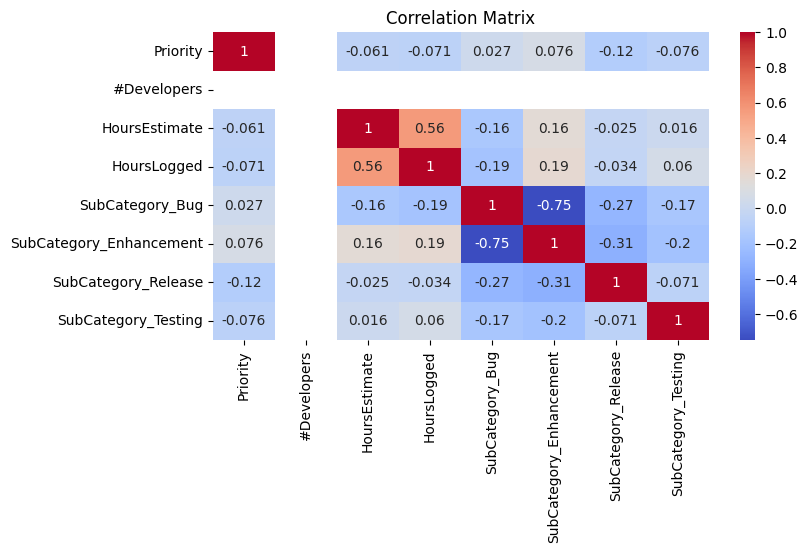

In [26]:
# correlation between the features and the target

correlation_matrix = clean_dataset.corr()
correlation_matrix['HoursLogged'].sort_values(ascending=False)

# plot the correlation matrix
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

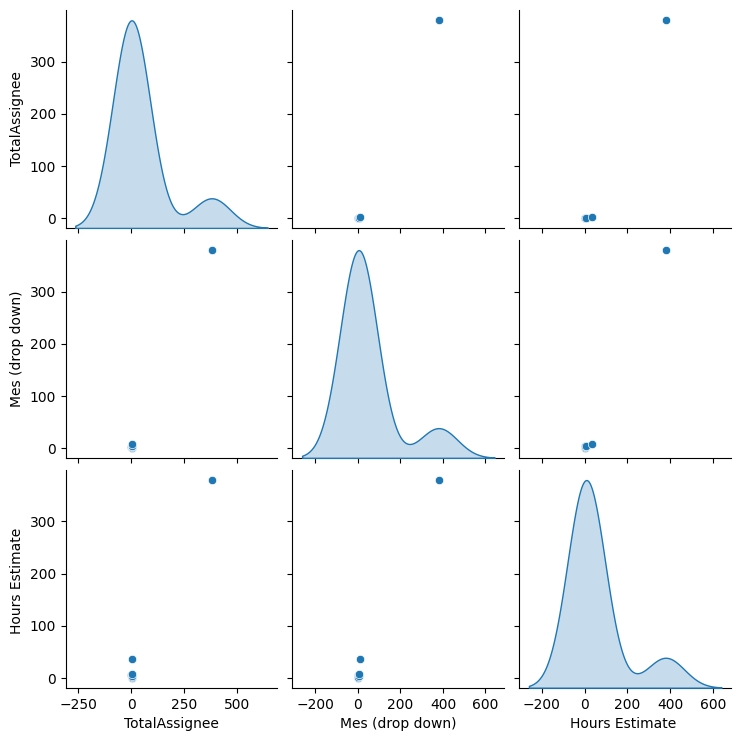

In [66]:
# correlation only between the features 
train_stats = train_dataset.describe()
train_stats.pop("Hours Logged")
sns.pairplot(train_stats[train_stats.columns], diag_kind="kde")

In [67]:
# another interesting statistics 
train_stats = train_dataset.describe()
train_stats.pop("Hours Logged")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
TotalAssignee,380.0,1.007895,0.088618,1.000000,1.0,1.0,1.0,2.0
Mes (drop down),380.0,4.339474,2.045142,1.000000,3.0,4.0,5.0,9.0
Hours Estimate,380.0,4.987939,5.596671,0.166667,1.0,3.0,7.5,36.0


### Feature prediction

The label "Hours Logged" is the actual goal for our model, we will remove it from every sample and keep it apart

In [68]:
train_label = train_dataset.pop('Hours Logged')
test_label = test_dataset.pop('Hours Logged')
validation_label = validation_dataset.pop('Hours Logged')

### Data normalization/Scaling

Subtract the mean of the training data and divide by the standard deviation of the training data.

In [69]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_validation_data = norm(validation_dataset)

In [70]:
# show a part of the normalized data
normed_train_data.head()

,TotalAssignee,Mes (drop down),Hours Estimate
194,-0.089088,-0.165990,0.538188
489,-0.089088,0.322973,-0.176523
368,-0.089088,-0.165990,-0.176523
40,-0.089088,-1.143917,3.218353
429,-0.089088,0.322973,-0.623217


## Building the Neural Network Model

## Firts Model
Two hidden layers with 50 neurons each

Learning rate at 0.001

In [74]:
def build_first_model_two_hidden_layers():
    model = Sequential(name = "FirstModelTwoHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(50, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(50, Activation('relu'), name='hidden_layer_2'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.001
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )

    return model

Summary of the model
Model: "FirstModelTwoHiddenLayers"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                40        
                                                                 
 dense_13 (Dense)            (None, 50)                550       
                                                                 
 dense_14 (Dense)            (None, 50)                2550      
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3191 (12.46 KB)
Trainable params: 3191 (12.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Second Model

Three hidden layers with 32, 64 and 128 neurons, respectively

Learning rate at 0.01

In [71]:
def build_second_model_three_hidden_layers():
    model = Sequential(name = "SecondModelThreeHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(32, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_2'))
    model.add(Dense(128, Activation('relu'), name='hidden_layer_3'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )

    return model

### Choose the model

To choose the model uncomment the line of the one that you want yo fit

In [72]:
# model = build_first_model_two_hidden_layers()
model = build_second_model_three_hidden_layers()

Test the model before training (this will use the initial weights) which in fact will generate random values. We will take the first 10 rows

In [73]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 78ms/step


array([[ 0.00670442],
       [-0.03710049],
       [-0.02124753],
       [ 0.03612434],
       [-0.05734   ],
       [-0.12659252],
       [-0.05422865],
       [-0.02197792],
       [-0.0748343 ],
       [-0.06731451]], dtype=float32)

Save checkpoints during training

In [74]:
checkpoint_path = r".\data-clickup.ckpt"

# Create a callback that saves the model's weights
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', # or val_accuracy if you have it.
                                                 save_best_only=True, # Default false. If you don't change the file name then the output will be overritten at each step and only the last model will be saved.
                                                 save_weights_only=True, # True => model.save_weights (weights and no structure, you need JSON file for structure), False => model.save (saves weights & structure)
                                                 verbose=0,
                                                  )

## Model training

In [81]:
%%time

# for first model
# epochs = 500
# batch_size = 30

# for second model
epochs = 500
batch_size = 40
# for third model

print("Summary of the model")
model.summary()

history = model.fit(
    normed_train_data,
    train_label,
    batch_size=batch_size,  
    epochs=epochs, 
    verbose=0,
    shuffle=True,
    steps_per_epoch = int(normed_train_data.shape[0] / batch_size),
    validation_data=(normed_validation_data, validation_label),
    callbacks=[
        tfdocs.modeling.EpochDots(),
        ckpt_callback,
    ]
)

Summary of the model
Model: "SecondModelThreeHiddenLayers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                40        
                                                                 
 hidden_layer_1 (Dense)      (None, 32)                352       
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                2112      
                                                                 
 hidden_layer_3 (Dense)      (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 10953 (42.79 KB)
Trainable params: 10953 (42.79 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________

In [82]:
print("Summary of the results after each epoch:")
history_dataset = pd.DataFrame(history.history)
history_dataset['epoch'] = history.epoch
history_dataset.tail()

Summary of the results after each epoch:


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,3.920016,1.071192,3.920016,21.147499,2.085161,21.147499,495
496,4.020885,1.080320,4.020885,17.348885,1.985928,17.348885,496
497,4.360200,1.139825,4.360200,16.740936,1.901230,16.740936,497
498,4.680119,1.229917,4.680119,19.413757,2.123807,19.413757,498
499,4.814353,1.217655,4.814353,22.025251,2.146518,22.025251,499


### Predicted and real values

Here we will see the first 10 rows of the predicted data, comparing it with the real one

In [83]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print("Predicted Hours Logged")
example_result

1/1 [==============================] - 0s 27ms/step
Predicted Hours Logged


array([[13.481136 ],
       [ 4.424667 ],
       [ 3.776887 ],
       [23.80823  ],
       [ 1.773361 ],
       [ 1.6721826],
       [ 4.78429  ],
       [ 7.219963 ],
       [ 1.0809761],
       [ 2.1686323]], dtype=float32)

In [84]:
print("Real Hours Logged")
train_label[:10]

Real Hours Logged


194    18.500000
489     4.000000
368     4.000000
40     23.000000
429     1.500000
60      2.416667
144     3.000000
63      7.500000
316     1.000000
486     1.000000
Name: Hours Logged, dtype: float64

## Evaluating the model

The metrics we choose to evaluate the model were **Mean Abs. Error** and **Mean squarred Error**

We will graph the error metrics across epochs and then see how the model evalutes itself

Text(0, 0.5, 'MAE [Hours Logged]')

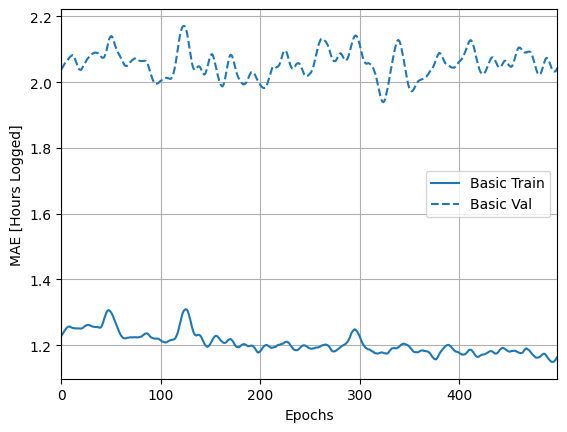

In [85]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Hours Logged]')

In [86]:
print("Error Rate on Train Sample")
loss, mae, mse = model.evaluate(normed_train_data, train_label, verbose=2)

print("Train set Mean Abs Error: {:5.2f} Hours Logged".format(mae))
print("Train set Mean Squared Error: {:5.2f} Hours Logged".format(mse))


Error Rate on Train Sample
12/12 - 0s - loss: 3.8854 - mae: 1.1320 - mse: 3.8854 - 48ms/epoch - 4ms/step
Train set Mean Abs Error:  1.13 Hours Logged
Train set Mean Squared Error:  3.89 Hours Logged


In [87]:
print("Error Rate on Validation Sample")
loss, mae, mse = model.evaluate(normed_validation_data, validation_label, verbose=2)

print("Train set Mean Abs Error: {:5.2f} Hours Logged".format(mae))
print("Train set Mean Squared Error: {:5.2f} Hours Logged".format(mse))

Error Rate on Validation Sample
7/7 - 0s - loss: 22.0252 - mae: 2.1465 - mse: 22.0252 - 36ms/epoch - 5ms/step
Train set Mean Abs Error:  2.15 Hours Logged
Train set Mean Squared Error: 22.03 Hours Logged


## Predicting the data

2/2 [==============================] - 0s 6ms/step


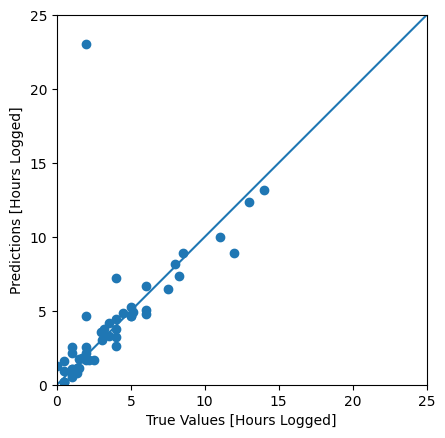

In [88]:
test_predictions = model.predict(normed_test_data).flatten()

axes = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [Hours Logged]')
plt.ylabel('Predictions [Hours Logged]')
lims = [0, 25]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
